# クラス分類学習モデルの作成、予測の実行

In [1]:
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import config

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# seedの固定
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    
# 再現性をもたせるためのseed固定
SEED = config.SEED
fix_seed(SEED)

# 決定木クラス分類モデルの作成・実行

決定木クラス分類モデルを作成、実行し、クラス分類に有用な特徴量を見つける  
精度は重視しない

In [2]:
df_MB_OS_status_in_5years_dropped=pd.read_pickle(config.INTERIM_PICKLE_PREPROCESSED_DIR+'/2.4-df_MB_OS_status_in_5years_dropped.pkl')
df_MB_OS_status_in_5years_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 0 to 1123
Data columns (total 56 columns):
 #   Column                                                          Non-Null Count  Dtype
---  ------                                                          --------------  -----
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   1042 non-null   bool 
 1   NPI                                                             1042 non-null   bool 
 2   CELLULARITY                                                     1042 non-null   bool 
 3   CHEMOTHERAPY                                                    1042 non-null   bool 
 4   ER_IHC                                                          1042 non-null   bool 
 5   HER2_SNP6                                                       1042 non-null   bool 
 6   HORMONE_THERAPY                                                 1042 non-null   bool 
 7   INFERRED_MENOPAUSAL_STATE                                       1042 

# 学習データ分割

1. X（説明変数）とy（目的変数）に分割(y=df['target'])
2. train_test_splitによる基本的なデータ分割（train:test=75%:25%）※層化検証など他の分割手法は後で実施  

In [3]:
# Xとyに分割
X=df_MB_OS_status_in_5years_dropped.drop('target', axis=1)
y=df_MB_OS_status_in_5years_dropped['target']
display(X.tail(), y.tail(), y.value_counts())

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,RADIO_THERAPY,ER_STATUS,HER2_STATUS,GRADE,PR_STATUS,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,COHORT_2.0,COHORT_3.0,COHORT_5.0,INTCLUST_10,INTCLUST_2,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,...,CLAUDIN_SUBTYPE_Her2,CLAUDIN_SUBTYPE_LumA,CLAUDIN_SUBTYPE_LumB,CLAUDIN_SUBTYPE_NC,CLAUDIN_SUBTYPE_Normal,CLAUDIN_SUBTYPE_claudin-low,THREEGENE_ER+/HER2- Low Prolif,THREEGENE_ER-/HER2-,THREEGENE_HER2+,HISTOLOGICAL_SUBTYPE_Lobular,HISTOLOGICAL_SUBTYPE_Medullary,HISTOLOGICAL_SUBTYPE_Mixed,HISTOLOGICAL_SUBTYPE_Mucinous,HISTOLOGICAL_SUBTYPE_Other,HISTOLOGICAL_SUBTYPE_Tubular/ cribriform,BREAST_SURGERY_MASTECTOMY,LATERALITY_Right,CANCER_TYPE_DETAILED_Breast Invasive Ductal Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Lobular Carcinoma,CANCER_TYPE_DETAILED_Breast Invasive Mixed Mucinous Carcinoma,CANCER_TYPE_DETAILED_Breast Mixed Ductal and Lobular Carcinoma,ONCOTREE_CODE_IDC,ONCOTREE_CODE_ILC,ONCOTREE_CODE_IMMC,ONCOTREE_CODE_MDLC
1119,True,True,True,False,True,True,True,True,True,False,True,True,True,True,True,True,True,False,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True
1120,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True
1121,False,True,True,False,True,True,False,True,True,False,True,True,True,True,True,True,True,False,False,True,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,True,False,False,False,True,False,False,False
1122,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True
1123,False,True,True,False,True,True,False,True,True,True,True,True,True,True,True,True,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False


1119    False
1120    False
1121    False
1122    False
1123    False
Name: target, dtype: bool

False    844
True     198
Name: target, dtype: int64

In [4]:
# trainとtestに分割

X_train, X_test, y_train, y_test=train_test_split(X,y, random_state=config.SEED)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(781, 55)

(261, 55)

(781,)

(261,)

False    638
True     143
Name: target, dtype: int64

False    206
True      55
Name: target, dtype: int64

# 決定木モデルの作成
 
sklearnの決定木モデルを作成する。  
精度の高いモデルを選びたいので、葉の数を2~50まで変動させ、accuracyを見る

## ベースラインの精度

全てFalseと予測（学習データはFalseが多いため）した場合のスコア

In [5]:
def show_scores(y_test, y_pred):
    print('accuracy: ', accuracy_score(y_test, y_pred))
    print('precision: ', precision_score(y_test, y_pred))
    print('recall: ', recall_score(y_test, y_pred))
    print('f1 score: ', f1_score(y_test, y_pred))

False    206
True      55
Name: target, dtype: int64

0.0

0.210727969348659

0.0

0.789272030651341

accuracy:  0.789272030651341
precision:  0.0
recall:  0.0
f1 score:  0.0


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


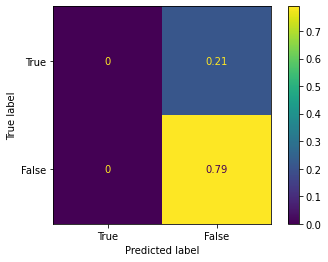

In [6]:
y_base=pd.Series([False for i in range(y_test.shape[0])], index=y_test.index)
display(y_test.value_counts())

cm=confusion_matrix(y_test, y_base, labels=[True, False], normalize='all')
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
disp.plot()

tn, fp, fn, tp = cm.ravel()
display(tn, fp, fn, tp)
# 各スコアを表示したが、ベースラインはtpとfpが0なので、accuracy以外のスコアは出ない
show_scores(y_test, y_base)

## 決定木モデルの構築・検証

決定木モデルを構築し、検証していく。  
パラメータを操作するため、forループで回し、最もスコアの高いものを見ていく。k


In [7]:
accuracies={}
precisions={}
recalls={}
f1_scores={}

for node in range(2,50):
    clf = DecisionTreeClassifier(max_leaf_nodes=node, random_state=config.SEED)
    clf = clf.fit(X_train, y_train)

    y_pred=clf.predict(X_test)
    
    accuracies[node]=accuracy_score(y_test, y_pred)
    precisions[node]=precision_score(y_test, y_pred)
    recalls[node]=recall_score(y_test, y_pred)
    f1_scores[node]=f1_score(y_test, y_pred)
    
    print('node: ',node)
    show_scores(y_test, y_pred)
    print('----------'*10)

node:  2
accuracy:  0.789272030651341
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
node:  3
accuracy:  0.789272030651341
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
node:  4
accuracy:  0.789272030651341
precision:  0.0
recall:  0.0
f1 score:  0.0
----------------------------------------------------------------------------------------------------
node:  5
accuracy:  0.8045977011494253
precision:  0.6
recall:  0.21818181818181817
f1 score:  0.32
----------------------------------------------------------------------------------------------------
node:  6
accuracy:  0.8045977011494253
precision:  0.5833333333333334
recall:  0.2545454545454545
f1 score:  0.3544303797468354
----------------------------------------------------------------------------------------------------
node:  7
accuracy:  0

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `ze

accuracy:  0.7816091954022989
precision:  0.4666666666666667
recall:  0.2545454545454545
f1 score:  0.32941176470588235
----------------------------------------------------------------------------------------------------
node:  45
accuracy:  0.7854406130268199
precision:  0.4827586206896552
recall:  0.2545454545454545
f1 score:  0.33333333333333337
----------------------------------------------------------------------------------------------------
node:  46
accuracy:  0.7854406130268199
precision:  0.4827586206896552
recall:  0.2545454545454545
f1 score:  0.33333333333333337
----------------------------------------------------------------------------------------------------
node:  47
accuracy:  0.7854406130268199
precision:  0.4838709677419355
recall:  0.2727272727272727
f1 score:  0.3488372093023256
----------------------------------------------------------------------------------------------------
node:  48
accuracy:  0.7854406130268199
precision:  0.4838709677419355
recall:  0.27272

'max node'

10

10

25

25

accuracy:  0.7969348659003831
precision:  0.5333333333333333
recall:  0.2909090909090909
f1_score:  0.3764705882352941


Text(0, 0.5, 'score')

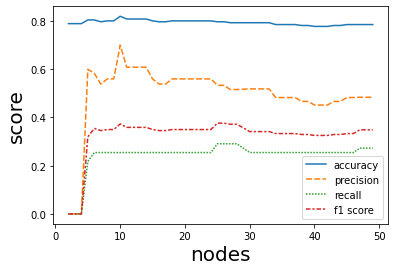

In [8]:
# 各スコアのプロット
display('max node',
        max(accuracies, key=accuracies.get), max(precisions, key=precisions.get), 
        max(recalls, key=recalls.get), max(f1_scores, key=f1_scores.get))

# f1_scoreが最も高いモデルのスコア
print('accuracy: ', accuracies[max(f1_scores, key=f1_scores.get)],)
print('precision: ', precisions[max(f1_scores, key=f1_scores.get)],)
print('recall: ', recalls[max(f1_scores, key=f1_scores.get)],)
print('f1_score: ', f1_scores[max(f1_scores, key=f1_scores.get)],)

df_score=pd.DataFrame([accuracies, precisions, recalls, f1_scores], 
             index=['accuracy', 'precision', 'recall', 'f1 score'],
            columns=accuracies.keys()).T
p=sns.lineplot(data=df_score)
p.set_xlabel("nodes", fontsize=20)
p.set_ylabel("score", fontsize=20)

In [9]:
clf = DecisionTreeClassifier(max_leaf_nodes=max(f1_scores, key=f1_scores.get), random_state=config.SEED)
clf = clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

0.06130268199233716

0.14942528735632185

0.05363984674329502

0.735632183908046

accuracy:  0.7969348659003831
precision:  0.5333333333333333
recall:  0.2909090909090909
f1 score:  0.3764705882352941


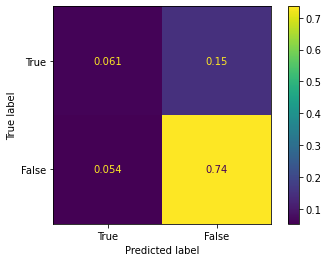

In [10]:
cm=confusion_matrix(y_test, y_pred, labels=[True, False], normalize='all')
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[True, False])
disp.plot()

tn, fp, fn, tp = cm.ravel()
display(tn, fp, fn, tp)
# 各スコアを表示したが、ベースラインはtpとfpが0なので、accuracy以外のスコアは出ない
show_scores(y_test, y_pred)